In [21]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)
print(parent)
%matplotlib widget

d:\Documents\git


In [22]:
from locale import normalize
import os
from src.transforms.image_processing.he_normalize import normalize_he_image
from src.deep_learning.architectures.graph_construction.hover_net import HoVerNet
from src.deep_learning.architectures.cancer_prediction.cell_encoder import CellEncoder
from src.deep_learning.architectures.cancer_prediction.cancer_gnn import CancerGNN
from PIL import Image
from torchvision.transforms import ToTensor
from src.transforms.cell_segmentation.hovernet_post_processing import instance_mask_prediction_hovernet, cut_img_from_tile
from src.transforms.graph_construction.node_embedding import generate_node_embeddings
from src.transforms.graph_construction.graph_extractor import extract_graph, cell_to_voting_graph
from torch_geometric.transforms import Compose, KNNGraph, RandomTranslate, Distance
import torch
from torch_geometric.loader.dataloader import DataLoader
import matplotlib.backends.backend_pdf
from src.utilities.img_utilities import tensor_to_numpy
import matplotlib.pyplot as plt
from src.transforms.cell_segmentation.percolation import hollow
from numpy.ma import masked_where
import numpy as np
import torch
from torch import Tensor, softmax
from src.transforms.image_processing.filters import glcm
from torchvision.transforms import Normalize
from src.deep_learning.explainability.concept_extraction import load_concept_information, disect_concept_graph
from src.deep_learning.explainability.explain_prediction import explain_prediction
from src.deep_learning.explainability.concept_discovery import graph_to_activation_concept_graph

In [23]:
hover_net_loc=os.path.join("model", "HoVerNet.ckpt")
resnet_encoder=os.path.join("model", "CellEncoder.ckpt")
gnn_loc=os.path.join("model", "GCN.ckpt")
concept_folder = os.path.join("data","CONCEPTS_32")

In [24]:
instance_to_test = "iv068"

img_loc = f"D:\\Documents\\git\\XAI-Cancer-Diagnosis\\XAI-Cancer-Diagnosis\\data\\raw\\unzipped\\BACH_TRAIN\\ICIAR2018_BACH_Challenge\\Photos\\Invasive\\{instance_to_test}.tif"
explainability_location = f"{instance_to_test}explain.png"

In [25]:
graph_trans = Compose([KNNGraph(6)])
gnn_args = {"HEIGHT": 7, "WIDTH": 32}
normalizer = Normalize(mean=[0.6441, 0.4474, 0.6039], std=[0.1892, 0.1922, 0.1535], inplace=True)

In [26]:
with torch.no_grad():
    # Load the Models
    hover_net = HoVerNet.load_from_checkpoint(hover_net_loc, categories=True).eval().cuda()
    resnet_encoder = CellEncoder.load_from_checkpoint(
        os.path.join("model", "CellEncoder.ckpt")).eval().cuda()
    gnn = CancerGNN.load_from_checkpoint(gnn_loc, **gnn_args).eval().cuda()

    # Load the image
    image = ToTensor()(Image.open(img_loc))

    # 1) Stain Normalisation

    normalized_image = normalize_he_image(image)

    # 2) Cell Segmentation

    # Create Instance Mask for cells
    instance_mask, category_mask = instance_mask_prediction_hovernet(
        hover_net, normalized_image.cuda(), pre_normalized=False, h=0.5, k=0.7)
    normalized_image_cropped = cut_img_from_tile(normalized_image, 128)

    del hover_net

    # 3) Graph Construction
    # Generate Cell Graph

    crop_graph = extract_graph(normalized_image_cropped.cpu(), instance_mask, category_mask).cuda()
    crop_graph = graph_trans(crop_graph)
    crop_graph.x = crop_graph.x.unflatten(1, (3, 64, 64))
    glcm_for_graph = torch.zeros((crop_graph.x.shape[0], 50))

    for i, img in enumerate(crop_graph.x):
        glcm_for_graph[i] = glcm(img, normalize=True)
    cell_graph = crop_graph.clone()
    cell_graph.x = generate_node_embeddings(imgs=crop_graph.x, resnet_encoder=resnet_encoder,
                                            num_neighbours=crop_graph.num_neighbours, cell_types=crop_graph.categories,
                                            glcm=glcm_for_graph.cuda())

    del resnet_encoder

    # 4) Graph Classification

    prediction = gnn.predict(cell_graph).cuda().squeeze()
    
    print(softmax(prediction, dim=0))



Using cache found in C:\Users\aless/.cache\torch\hub\pytorch_vision_v0.10.0


Singular
tensor([0.3665, 0.0249, 0.3032, 0.3054], device='cuda:0')


In [27]:
# 5) GCExplainability
with torch.no_grad():
    concept_means, exemplary_images, class_concept_prob, mu, sigma = load_concept_information(concept_folder)
    concept_graph = graph_to_activation_concept_graph(gnn,
                                                        cell_graph, concept_means, 32, mu, sigma)


## Series of visualizations

In [28]:

from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from matplotlib import cm

In [32]:
def vizualize_concept_graph(concept_graph, original_image, concept_probs):
    k = concept_graph.x.shape[1]
    x = concept_graph.x
    edge_index  = concept_graph.edge_index
    pos = {i:tuple(concept_graph.pos[i]) for i in range(len(concept_graph.pos))}
    colours = cm.rainbow(np.linspace(0,1,k))
    concept_importance = [concept_probs[i,3] > 50 for i in range(len(concept_probs))]
    for i in range(k):
        if concept_importance[i]:
            print( f"Concept {i} is important and appear {x.argmax(dim=1).eq(i).sum().item()} times" )
    colours = [(*colours[i][:3],0.15) if not concept_importance[i] else colours[i] for i in range(k)]
    node_colours = [colours[i] for i in x.argmax(dim=1)]
    
    g = Data(x=x,edge_index=edge_index,pos=pos)
    G = to_networkx(concept_graph,to_undirected=True)

   # f,ax = plt.subplots(1,1,figsize=(20,20))
    plt.figure(figsize=(concept_graph.pos[:,0].max()/100,concept_graph.pos[:,1].max()/100))
    plt.axis([0,concept_graph.pos[:,0].max(),concept_graph.pos[:,1].max(),0])
    nx.draw(G,pos=pos,node_color=node_colours,node_size=100)
    # Also draw the original image
    plt.imshow(original_image.permute(1,2,0))
    # Also provide a legend for the concepts (which is the same as the node colours)
    
    plt.legend([f"Concept {i}" for i in range(k)])
    print(concept_probs)
    
    plt.show()

Concept 1 is important and appear 17 times
Concept 10 is important and appear 17 times
Concept 11 is important and appear 32 times
Concept 13 is important and appear 662 times
Concept 15 is important and appear 46 times
Concept 23 is important and appear 0 times
[[40 32 10 16]
 [ 0  2 44 52]
 [ 2  0 81 15]
 [ 3 59 16 20]
 [ 6 72 10 11]
 [18  0 61 19]
 [ 4 87  2  5]
 [ 1  0 49 48]
 [11 26 60  2]
 [ 0 81 14  3]
 [ 1 15  6 76]
 [ 0  0 28 70]
 [33 15 44  6]
 [ 6  2 35 55]
 [ 2  6 69 21]
 [ 1  8 20 69]
 [12 55 18 14]
 [53 42  3  1]
 [43  0 52  3]
 [10 53  6 30]
 [ 0 11 53 33]
 [ 0 14 85  0]
 [16 17 29 35]
 [ 0  2  8 88]
 [ 8 55 14 20]
 [50  1 35 12]
 [ 1 11 67 18]
 [ 0  0 71 27]
 [67 22  4  5]
 [ 0  0 84 15]
 [ 3  0 74 22]
 [42  8 28 20]]


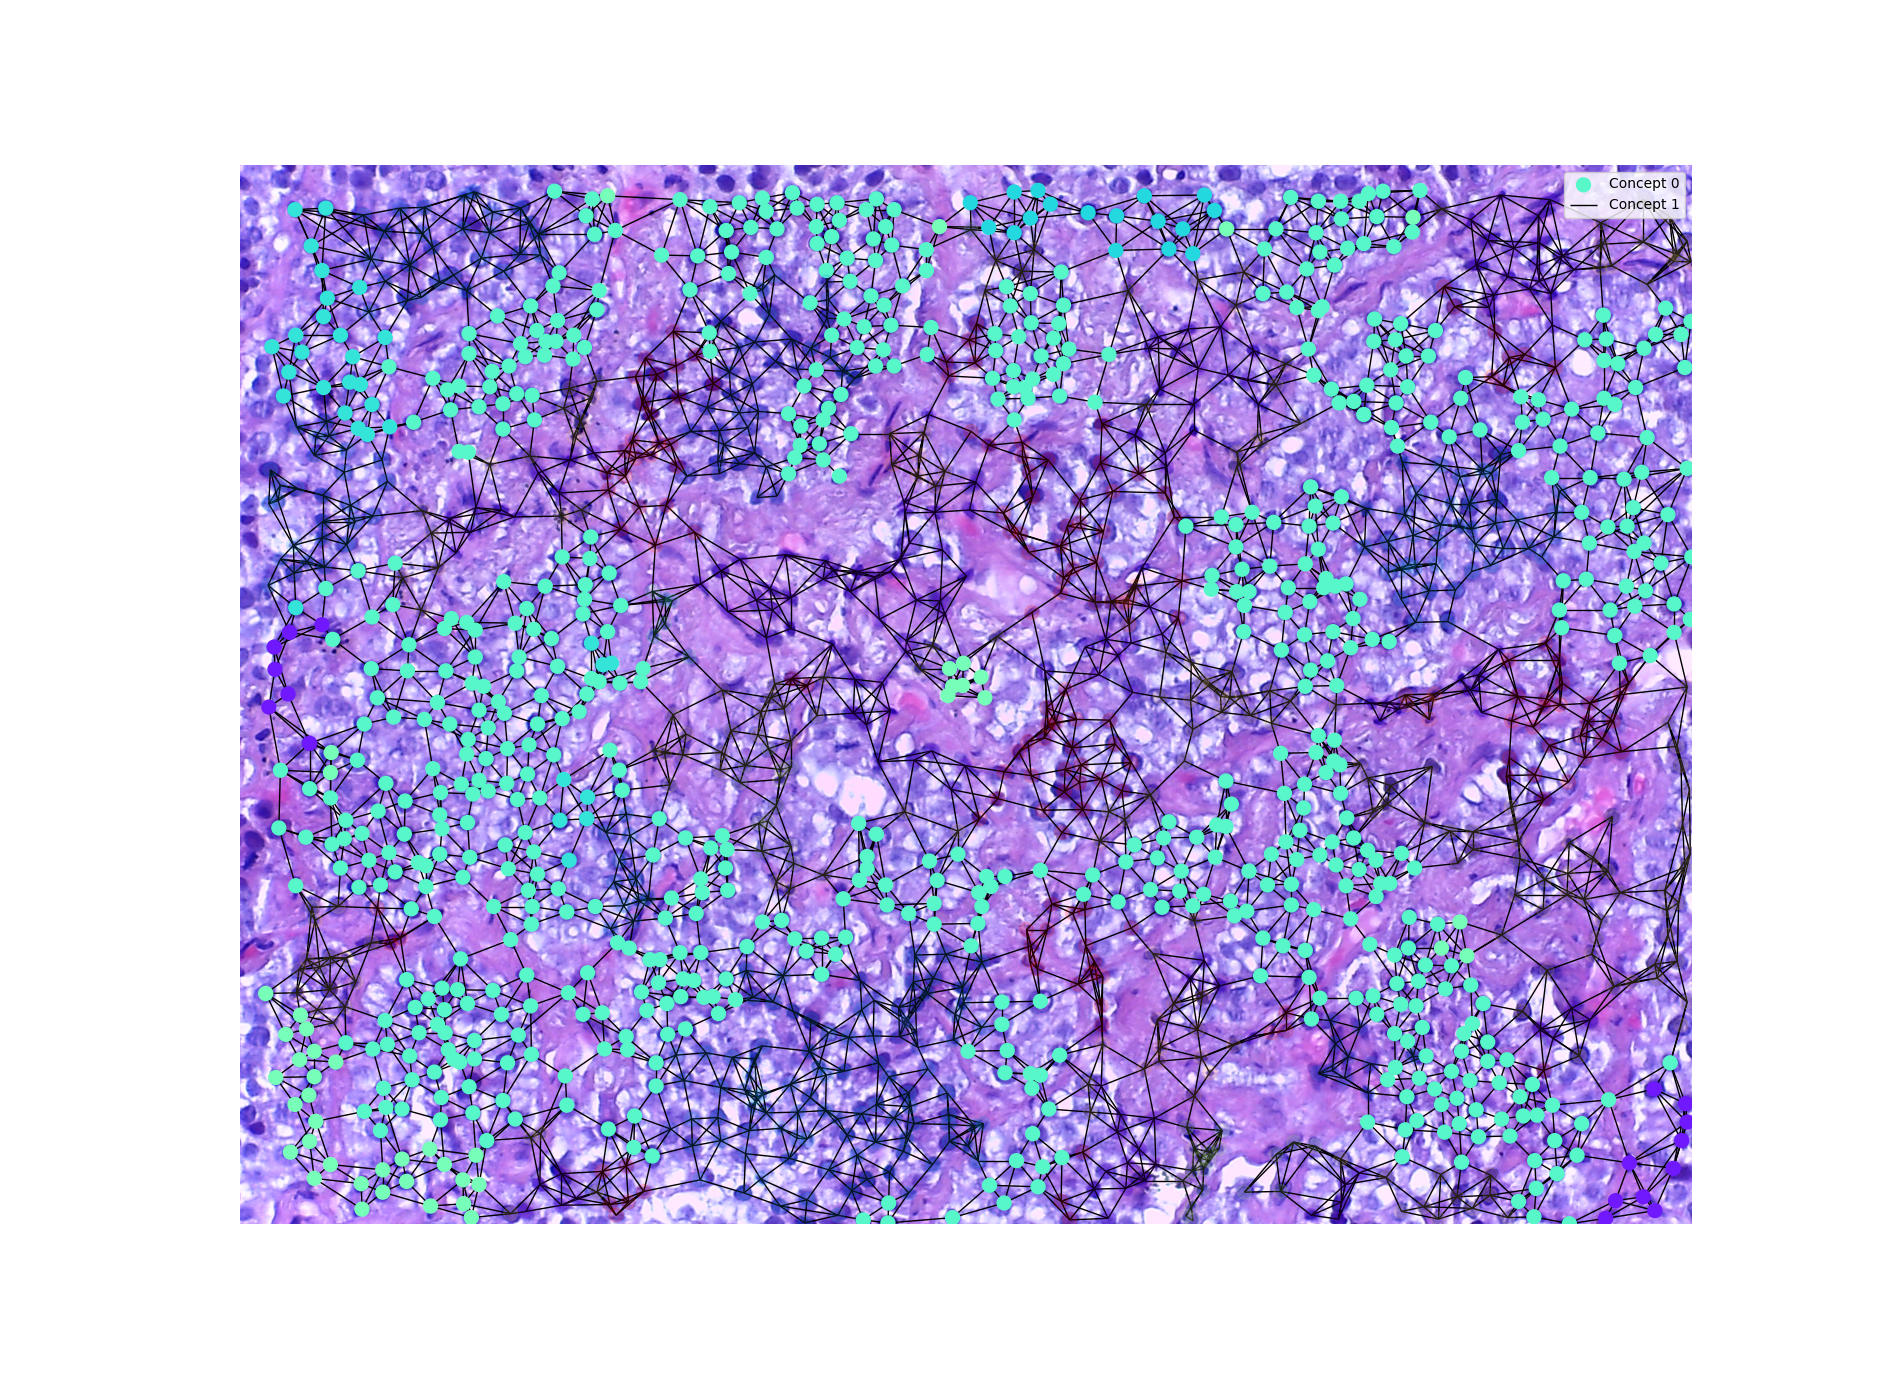

In [33]:
from src.vizualizations.graph_viz import *

vizualize_concept_graph(concept_graph.cpu(),normalized_image_cropped,class_concept_prob)